In [23]:
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from skimage.transform import rotate, warp
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [24]:
train_path="C:/Users/Yoga/Downloads/archive (2)/Train.csv"
test_path = "C:/Users/Yoga/Downloads/archive (2)/Test.csv"
base_path = "C:/Users/Yoga/Downloads/archive (2)"

In [25]:
classes={ 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits',
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

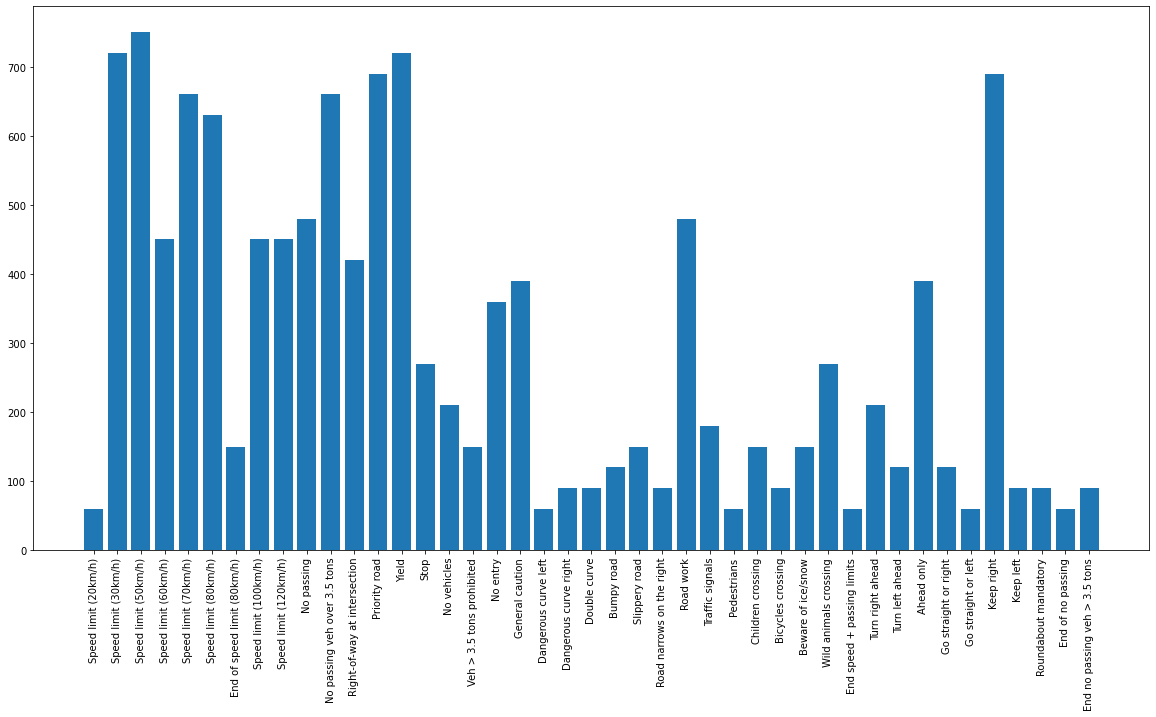

In [26]:
data = pd.read_csv(test_path)
data_group = data.groupby("ClassId")["Path"].count()
classId=[]
count=[]
for i in range(len(data_group)):
    li = data_group.tolist()
    classId.append(classes[i])
    count.append(data_group[i])
plt.figure(figsize=(20,10))
plt.bar(classId,count)
plt.xticks(classId,rotation='vertical')
plt.show()

In [27]:
data.head(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [28]:
def get_train_data(path):
    images,labels=[],[]
    data = pd.read_csv(path)
    for i,j in tqdm(data.iterrows()):
        label,img_path = j['ClassId'],j['Path']
        image_path=base_path+"/"+img_path
        #print(image_path)
        image = cv.imread(image_path)
        image = cv.resize(image,(32,32))
        image=image/255
        images.append(image)
        labels.append(label)
    images=np.array(images)
    labels=np.array(labels)
    return images,labels
        

In [29]:
images,labels=get_train_data(train_path)
print(images.shape)

39209it [00:56, 695.59it/s] 


(39209, 32, 32, 3)


In [30]:
test_images,test_labels = get_train_data(test_path)
print(test_images.shape)

12630it [00:13, 941.44it/s]


(12630, 32, 32, 3)


In [31]:
def imageAug(x,y):
    train_x,train_y=[],[]
    for i in tqdm(range(x.shape[0])):
        train_x.append(x[i])
        train_x.append(rotate(x[i], angle=random.randint(45,270), mode = 'wrap'))
        train_x.append(np.fliplr(x[i]))
        train_x.append(np.flipud(x[i]))
        for j in range(4):
            train_y.append(y[i])
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    return train_x,train_y

In [32]:
images_aug,labels_aug = imageAug(images,labels)

100%|██████████████████████████████████████████████████████████████████████████| 39209/39209 [00:21<00:00, 1816.55it/s]


In [33]:
print(images_aug.shape,labels_aug.shape)

(156836, 32, 32, 3) (156836,)


In [34]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(images_aug,labels_aug,test_size=0.2)


In [35]:
print(X_train.shape,X_val.shape)

(125468, 32, 32, 3) (31368, 32, 32, 3)


C:\Users\Yoga\anaconda3\envs\py_pro\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  after removing the cwd from sys.path.


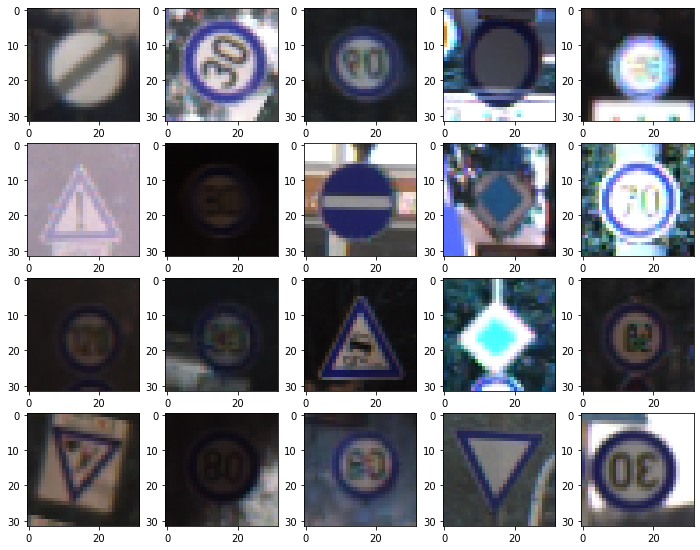

In [36]:
def imsho(imgs):
    plt.figure(figsize=(12,12))
    for i in range(len(imgs)):
        plt.subplot(len(imgs)/4,len(imgs)/4,i+1)
        plt.imshow(imgs[i])
    plt.show()
imsho(X_train[:20])

my_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(images.mean(), images.std()),

 ])
images_aug=[]
for img in tqdm(images):
    images_aug.append(my_transform(img))


train_x,train_y = imageAug(X_train,y_train)

In [37]:
X_train_final = X_train.reshape(125468,3,32,32)
X_train_final = torch.from_numpy(X_train_final)
X_train_final = X_train_final.float()


y_train_final = torch.from_numpy(y_train)
y_train_final = y_train_final.long()
print(X_train_final.shape)

torch.Size([125468, 3, 32, 32])


In [38]:
X_val_final = X_val.reshape(31368,3, 32, 32)
X_val_final =torch.from_numpy(X_val_final)
X_val_final = X_val_final.float()
print(X_val_final.shape)

y_val_final = torch.from_numpy(y_val)
y_val_final = y_val_final.long()

torch.Size([31368, 3, 32, 32])


In [39]:
X_test = test_images.reshape(12630,3, 32, 32)
X_test =torch.from_numpy(X_test)
X_test = X_test.float()
print(X_test.shape)

y_test = torch.from_numpy(test_labels)
y_test = y_test.long()

torch.Size([12630, 3, 32, 32])


In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,32,3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.conv3 = nn.Conv2d(64,128,3)
        self.conv4 = nn.Conv2d(128,256,3)


        self.pool = nn.MaxPool2d(2, 2)
        
        self.drop = nn.Dropout(p=0.25)
        
        self.batchN1 = nn.BatchNorm2d(32)
        self.batchN2 = nn.BatchNorm2d(64)
        self.batchN3 = nn.BatchNorm2d(128)
        self.batchN4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256*2*2, 128 )
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256,512)
        self.fc4 = nn.Linear(512,43)

    def forward(self, x):
        x= F.relu(self.conv1(x))
        x= self.batchN1(x)
        x= self.drop(x)
        
        x = F.relu(self.conv2(x))
        x= self.batchN2(x)
        x=self.pool(x)
        x= self.drop(x)
        
        x = F.relu(self.conv3(x))
        x= self.batchN3(x)
        x=self.pool(x)
        x=self.drop(x)
        
        x = F.relu(self.conv4(x))
        x= self.batchN4(x)
        x=self.pool(x)
        x=self.drop(x)
        

        x = x.view(-1, 256*2*2)
        
        x = F.relu(self.fc1(x))
        x= self.drop(x)
        
        x = F.relu(self.fc2(x))
        x=self.drop(x)
        
        x = F.relu(self.fc3(x))
        x=self.drop(x)
        
        x = self.fc4(x)
        return x


net = Net()
net=net.cuda()
net

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.25, inplace=False)
  (batchN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchN3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchN4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=43, bias=True)
)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.0001)
criterion = criterion.cuda()

In [42]:
running_loss = []
batch_size =32

for epoch in range(10):
    permutation = torch.randperm(X_train_final.size()[0])
    train_loss=[]
    for i in tqdm(range(0,X_train_final.size()[0], batch_size)):
        
        ind = permutation[i:i+batch_size]
        x_batch,y_batch = X_train_final[ind],y_train_final[ind]
        
        x_batch = x_batch.cuda()
        y_batch=y_batch.cuda()
            
        #print(x_batch.shape)
        optimizer.zero_grad()
        outputs = net(x_batch)
        loss = criterion(outputs, y_batch)
        
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    running_loss.append(np.average(train_loss))
        
print('Finished Training')

100%|██████████████████████████████████████████████████████████████████████████████| 3921/3921 [01:15<00:00, 51.96it/s]

Finished Training


In [86]:
torch.save(net,'net_final.pt')

torch.cuda.empty_cache()

Text(0, 0.5, 'Loss')

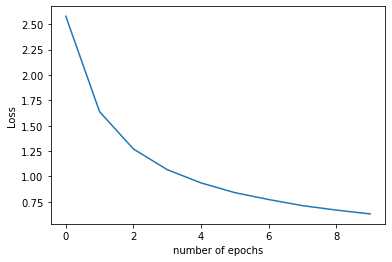

In [43]:
plt.plot(running_loss)
plt.xlabel("number of epochs")
plt.ylabel("Loss")

In [20]:
net= torch.load('C:/Users/Yoga/net_final.pt')

In [53]:
batch_size =32
preds= []
actual=[]
loss=[]
accuracy=[]

final_accuracy=[]
final_loss=[]

class_correct=list(0. for i in range(43))
class_total=list(0. for i in range(43))
permutation = torch.randperm(X_val_final.size()[0])
    
for i in tqdm(range(0,X_val_final.size()[0], batch_size)):
        
    ind = permutation[i:i+batch_size]
    x_batch,y_batch = X_val_final[ind],y_val_final[ind]
        
    x_batch = x_batch.cuda()
    y_batch=y_batch.cuda()
            
    with torch.no_grad():
        outputs = net(x_batch)
    
    lossess = criterion(outputs,y_batch)
    lossess=lossess.cpu()
    loss.append(lossess.item())
    
    
    outputs=outputs.cpu()
    li = list(outputs.numpy())
    pred = np.argmax(li,axis=1)
    preds.append(pred)
    actual.append(y_batch)

ls=0
for i in range(len(preds)):
    accu = accuracy_score(actual[i].cpu(),preds[i])
    ls = loss[i]
    #accuracy.append(accuracy_score(actual[i].cpu(),preds[i]))
    if(i%10==0):
        final_loss.append(np.average(ls))
        final_accuracy.append(np.average(accu))

print("Validation accuracy ",np.average(final_accuracy))
print("Validation Loss",np.average(final_loss))

for i in range(0,len(actual)):
    for j in range(0,len(actual[i])):
        #print(actual[i])
        ind = actual[i][j]
        class_correct[ind] +=1 if(actual[i][j]==preds[i][j]) else 0
        class_total[ind]+=1
for  i in range(43):
    print("Accuracy of %5s : %2d %%" %(classes[i],100*class_correct[i]/class_total[i]))

100%|███████████████████████████████████████████████████████████████████████████████| 981/981 [00:04<00:00, 233.09it/s]


Validation accuracy  0.7891414141414141
Validation Loss 0.6578754409395083
Accuracy of Speed limit (20km/h) : 56 %
Accuracy of Speed limit (30km/h) : 82 %
Accuracy of Speed limit (50km/h) : 75 %
Accuracy of Speed limit (60km/h) : 68 %
Accuracy of Speed limit (70km/h) : 74 %
Accuracy of Speed limit (80km/h) : 68 %
Accuracy of End of speed limit (80km/h) : 81 %
Accuracy of Speed limit (100km/h) : 79 %
Accuracy of Speed limit (120km/h) : 78 %
Accuracy of No passing : 87 %
Accuracy of No passing veh over 3.5 tons : 92 %
Accuracy of Right-of-way at intersection : 82 %
Accuracy of Priority road : 97 %
Accuracy of Yield : 88 %
Accuracy of  Stop : 94 %
Accuracy of No vehicles : 87 %
Accuracy of Veh > 3.5 tons prohibited : 88 %
Accuracy of No entry : 97 %
Accuracy of General caution : 76 %
Accuracy of Dangerous curve left : 53 %
Accuracy of Dangerous curve right : 36 %
Accuracy of Double curve : 38 %
Accuracy of Bumpy road : 65 %
Accuracy of Slippery road : 64 %
Accuracy of Road narrows on the 

In [54]:
batch_size =32
preds= []
actual=[]
loss=[]
accuracy=[]
final_accuracy=[]
final_loss=[]
class_Correct=[]
class_total =[]

permutation = torch.randperm(X_test.size()[0])
class_correct=list(0. for i in range(43))
class_total=list(0. for i in range(43))

for i in tqdm(range(0,X_test.size()[0], batch_size)):
        
    ind = permutation[i:i+batch_size]
    x_batch,y_batch = X_test[ind],y_test[ind]
        
    x_batch = x_batch.cuda()
    y_batch=y_batch.cuda()
            
    with torch.no_grad():
        outputs = net(x_batch)
    
    lossess = criterion(outputs,y_batch)
    lossess=lossess.cpu()
    loss.append(lossess.item())
    
    outputs=outputs.cpu()
    li = list(outputs.numpy())
    pred = np.argmax(li,axis=1)
    
    preds.append(pred)
    actual.append(y_batch)
    

ls=0
for i in range(len(preds)):
    accu = accuracy_score(actual[i].cpu(),preds[i])
    ls = loss[i]
    if(i%10==0):
        final_loss.append(np.average(ls))
        final_accuracy.append(np.average(accu))
print("Test accuracy ",np.average(final_accuracy))
print("Test Loss",np.average(final_loss))

for i in range(0,len(actual)):
    for j in range(0,len(actual[i])):
        #print(actual[i])
        ind = actual[i][j]
        class_correct[ind] +=1 if(actual[i][j]==preds[i][j]) else 0
        class_total[ind]+=1
for  i in range(43):
    print("Accuracy of %5s : %2d %%" %(classes[i],100*class_correct[i]/class_total[i]))

100%|███████████████████████████████████████████████████████████████████████████████| 395/395 [00:01<00:00, 238.59it/s]


Test accuracy  0.70859375
Test Loss 1.06971665173769
Accuracy of Speed limit (20km/h) : 28 %
Accuracy of Speed limit (30km/h) : 75 %
Accuracy of Speed limit (50km/h) : 81 %
Accuracy of Speed limit (60km/h) : 60 %
Accuracy of Speed limit (70km/h) : 62 %
Accuracy of Speed limit (80km/h) : 68 %
Accuracy of End of speed limit (80km/h) : 62 %
Accuracy of Speed limit (100km/h) : 68 %
Accuracy of Speed limit (120km/h) : 70 %
Accuracy of No passing : 85 %
Accuracy of No passing veh over 3.5 tons : 89 %
Accuracy of Right-of-way at intersection : 75 %
Accuracy of Priority road : 88 %
Accuracy of Yield : 89 %
Accuracy of  Stop : 92 %
Accuracy of No vehicles : 84 %
Accuracy of Veh > 3.5 tons prohibited : 90 %
Accuracy of No entry : 85 %
Accuracy of General caution : 63 %
Accuracy of Dangerous curve left : 45 %
Accuracy of Dangerous curve right : 15 %
Accuracy of Double curve : 32 %
Accuracy of Bumpy road : 57 %
Accuracy of Slippery road : 46 %
Accuracy of Road narrows on the right : 40 %
Accuracy 

In [140]:

import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy
import torch

In [141]:
net= torch.load('C:/Users/Yoga/net_final.pt')

In [250]:
window=tk.Tk()
window.geometry("600x500")
window.title("traffic sign Classification")

label1=tk.Label(text=" ")
label1.grid(column=0,row=0)

label2 =tk.Label()
label2.grid(column=1,row=1)

button1 = tk.Button(text = "Predict",fg ="blue",command=classify)
button1.grid(column=2,row=7)
button1 = tk.Button(text = "upload an image",fg ="blue",command=upload_image)
button1.grid(column=2,row=6)

window.mainloop()

C:/Users/Yoga/Downloads/archive (2)/Test/00001.png
Speed limit (30km/h)


In [247]:
def classify(file_path):
    global label_packed
    img = cv.imread(file_path)
    image = cv.resize(img,(32,32))
    image=image/255
    img = image.reshape(1,3,32,32)
    img_final = torch.from_numpy(img)
    img_final = img_final.float().cuda()
    pred=net(img_final).cpu()
    with torch.no_grad():
        li = list(pred.numpy())
        pred_f = np.argmax(li,axis=1)
    print(classes[pred_f.item()])
    label1.configure(foreground='#011638', text=classes[pred_f.item()]) 


In [55]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy

In [56]:
def upload_image():
    try:
        path=filedialog.askopenfilename()
        img=Image.open(path)
        img=ImageTk.PhotoImage(img)
        sign_image.configure(image=img)
        sign_image.image=img
        label.configure(text='')
        show_classify_button(path)
    except:
        pass

In [57]:
def show_classify_button(path):
    b=Button(top,text="Classify Image",
   command=lambda: classify(path),padx=10,pady=5)
    b.configure(background='#364156', foreground='white')
    b.place(relx=0.79,rely=0.46)

In [58]:
def classify(file_path):
    global label_packed
    
    img = cv.imread(file_path)
    image = cv.resize(img,(32,32))
    image=image/255
    img = image.reshape(1,3,32,32)
    img_final = torch.from_numpy(img)
    img_final = img_final.float().cuda()
    pred=net(img_final).cpu()
    with torch.no_grad():
        li = list(pred.numpy())
        pred_f = np.argmax(li,axis=1)
    print(classes[pred_f.item()])
    sign=classes[pred_f.item()]
    label.configure(foreground='#011638', text=sign)


In [59]:
top=tk.Tk()
top.geometry('800x600')
top.title('Traffic sign Classification')
top.configure(background='#B0E0E6')

label=Label(top)
sign_image = Label(top)
upload=Button(top,text="Upload an image",command=upload_image,
  padx=10,pady=5)
upload.configure(background='#2E8B57', foreground='white')
upload.pack(side=BOTTOM,pady=50)

sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="Traffic Sign Classification",pady=20, font=('bold'))
heading.configure(background='#B0E0E6',foreground='#364156')
heading.pack()
top.mainloop()

Ahead only
Children crossing
Speed limit (80km/h)
Speed limit (30km/h)
Priority road
Traffic signals
